In [1]:
%matplotlib inline
import random
import math
import os
import cv2
import torch.nn as nn
import torch
import torchvision
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageDraw
import matplotlib.patches as patches
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

In [2]:
data = pd.read_csv('meta.csv')
data.head()


,path,class
0,./imdb_crop/38/nm0647638_rm3867515136_1977-5-3...,Eric Christian Olsen
1,./imdb_crop/11/nm0267511_rm18862336_1982-3-25_...,Sean Faris
2,./imdb_crop/36/nm0933836_rm1606719488_1944-3-6...,Mary Wilson
3,./imdb_crop/14/nm0842314_rm1893177600_1971-0-0...,Vonte Sweet
4,./imdb_crop/37/nm0341737_rm1121027840_1968-12-...,Rachel Griffiths


In [ ]:
random.seed(42)

In [ ]:
print(data.columns)
print(data.shape[0]//32)
print("number of classes ",len(set(data['class'])))
len(set(data['class']))

In [ ]:
data['class'][3]

In [ ]:
histogram = {}
for name in data['class']:
    if name in histogram:
        histogram[name] += 1
    else:
        histogram[name] = 1

In [ ]:
'''
Get a list of keys from dictionary which has the given value
'''
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = [key  for (key, value) in dictOfElements.items() if value == valueToFind]
    return  listOfKeys

In [ ]:
class_max = getKeysByValue(histogram, max(histogram.values()))
class_min = getKeysByValue(histogram, min(histogram.values()))
print("classes with maximum examples {} and the number of examples {}".format(class_max, max(histogram.values())))
print("\n")
#print("classes with minimum examples {} and the number of examples {}".format(class_min, min(histogram.values())))
print("number of classes with one example {}".format(len(class_min)))
len(histogram)

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,csv_file,transform = None, should_invert=True):
        """
        Args: 
            csv_file (string): Path to the csv file with labels
            transform (callable, optional): Optional transform to be 
            applied on a sample.            
        """
        self.celeb_frame = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.celeb_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        n = random.randint(0, len(self.celeb_frame)-1)
        img0_tuple = (os.path.join(self.celeb_frame.iloc[n, 0]), self.celeb_frame.iloc[n,1])
        
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                m = random.randint(0, len(self.celeb_frame)-1)
                img1_tuple = (os.path.join(self.celeb_frame.iloc[m,0]), self.celeb_frame.iloc[m,1])
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                m = random.randint(0, len(self.celeb_frame)-1)
                img1_tuple = (os.path.join(self.celeb_frame.iloc[m,0]), self.celeb_frame.iloc[m,1])
                if img0_tuple[1] != img1_tuple[1]:
                    break
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        
        
        # Grey Images exist: 11452         
        if img0.mode == "L":
            cv_image = np.array(img0)
            img0 = cv2.cvtColor(cv_image, cv2.COLOR_GRAY2RGB)
            img0 = Image.fromarray(img0)
            
        # Grey Images exist: 11452         
        if img1.mode == "L":
            cv_image = np.array(img1)
            img1 = cv2.cvtColor(cv_image, cv2.COLOR_GRAY2RGB)
            img1 = Image.fromarray(img1)
                
        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array(
        [int(img1_tuple[1]!=img0_tuple[1])], dtype=np.float32))
        

In [4]:
siamese_dataset = SiameseNetworkDataset(csv_file='meta.csv',
                                       transform = transforms.Compose(
                                       [transforms.Resize((224,224)),
                                       transforms.ToTensor()
                                       ]))                                    
                                                                           
                                       

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


In [ ]:

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=4)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]))
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64), )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128), )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),)
                

        self.fc1 = nn.Sequential(
            nn.Linear(51200, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128))

    def forward_once(self, x):
        
        output = F.max_pool2d(self.conv1(x), 2)
        output = F.max_pool2d(self.conv2(output), 2)
        output = F.max_pool2d(self.conv3(output), 2)
        output = F.max_pool2d(self.conv4(output), 2)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [6]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.margin = 2.0#margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [7]:
len(siamese_dataset)

224840

In [8]:
validation_split = 0.8
train_size = int(validation_split*len(siamese_dataset))
test_size = len(siamese_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(siamese_dataset,
                                                            [train_size, test_size])


In [ ]:
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=8)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,100):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.to(device), img1.to(device) , label.to(device)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [ ]:
# Save the model
torch.save(net, '.')

In [ ]:
# Save the model
torch.save(net, './network.pth')

In [9]:
device = torch.device("cuda")
net = SiameseNetwork().to(device)


In [16]:
net = torch.load('siamese_temp.pt', map_location="cuda:0")
net.eval()

SiameseNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=

In [17]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(140, 26, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

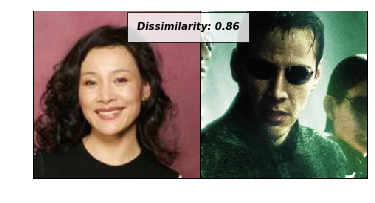

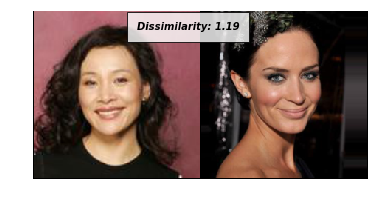

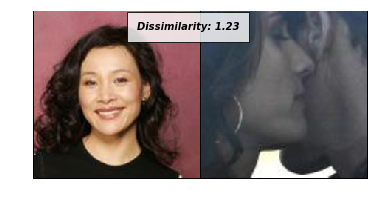

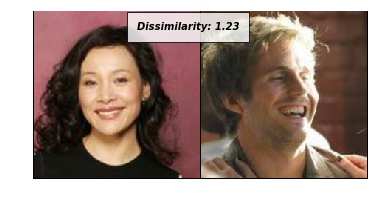

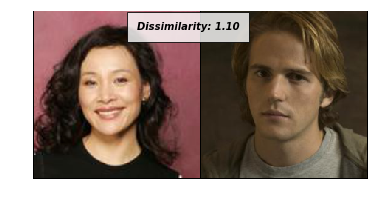

In [19]:
test_dataloader = DataLoader(test_dataset,
                        num_workers=4,
                        batch_size=1,
                            shuffle=True)
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)
#print("input1",x0.size())
for i in range(5):
    _,x1,label2 = next(dataiter)
    #print("input2",x1.size())
    concatenated = torch.cat((x0,x1),0)    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    #imshow(torchvision.utils.make_grid(concatenated))